In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2

In [2]:
labels = os.listdir("./train")

In [3]:
labels

['Closed', 'no_yawn', 'Open', 'yawn']

In [4]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread("./train/Closed/_0.jpg"))

In [5]:
a = plt.imread("./train/yawn/10.jpg")

In [6]:
a.shape


(480, 640, 3)

In [7]:
def face_for_yawn(direc="./train", face_cas_path="./haarcascade_frontalface_alt.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


In [8]:
def get_data(dir_path="./train/", face_cas="./haarcascade_frontalface_default.xml", eye_cas="./haarcascade_eye.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [9]:
data_train = get_data()

2
3


In [10]:
def append_data():
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no,dtype=object)

In [11]:
new_data = append_data()

0
1
2
3


In [12]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

In [13]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

In [14]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [15]:
y = np.array(y)

In [16]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [17]:
len(X_test)

535

In [18]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [19]:
tf.__version__

'2.4.1'

In [20]:
import keras
keras.__version__

'2.4.3'

In [21]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

In [22]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 143, 143, 256)     7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 71, 71, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 69, 69, 128)       295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        1

In [23]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/50
39/39 [==============================] - 145s 4s/step - loss: 1.2075 - accuracy: 0.4469 - val_loss: 1.0691 - val_accuracy: 0.5720
Epoch 2/50
39/39 [==============================] - 137s 4s/step - loss: 0.6289 - accuracy: 0.7619 - val_loss: 0.3234 - val_accuracy: 0.8561
Epoch 3/50
39/39 [==============================] - 138s 4s/step - loss: 0.3717 - accuracy: 0.8448 - val_loss: 0.2563 - val_accuracy: 0.8785
Epoch 4/50
39/39 [==============================] - 141s 4s/step - loss: 0.3594 - accuracy: 0.8535 - val_loss: 0.1952 - val_accuracy: 0.9327
Epoch 5/50
39/39 [==============================] - 137s 4s/step - loss: 0.2777 - accuracy: 0.8979 - val_loss: 0.1840 - val_accuracy: 0.9178
Epoch 6/50
39/39 [==============================] - 138s 4s/step - loss: 0.2389 - accuracy: 0.9133 - val_loss: 0.1963 - val_accuracy: 0.9159
Epoch 7/50
39/39 [==============================] - 139s 4s/step - loss: 0.1941 - accuracy: 0.9176 - val_loss: 0.1920 - val_accuracy: 0.9065
Epoch 8/50
39

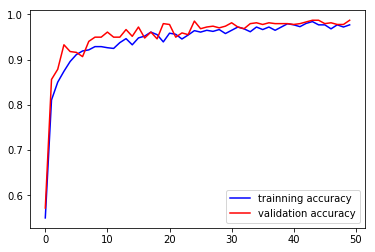

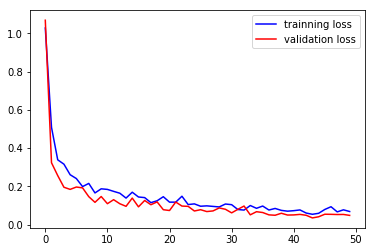

In [24]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [25]:
model.save("drowiness_new6.h5")

In [12]:
prediction = model.predict(X_test)

NameError: name 'X_test' is not defined

In [27]:
prediction

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [28]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [29]:
#from sklearn.metrics import classification
#print(classification_report(np.argmax(y_test, axis=1), prediction, target_names=labels_new))

In [30]:
#labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas="./haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("./drowiness_new6.h5")

In [17]:
prediction = model.predict([prepare("./train/no_yawn/1067.jpg")])
np.argmax(prediction)

1

In [16]:
prediction = model.predict([prepare("./train/Closed/_101.jpg")])
np.argmax(prediction)

1

In [33]:
prediction = model.predict([prepare("./train/Open/_104.jpg")])
np.argmax(prediction)

3

In [14]:
prediction = model.predict([prepare("./train/yawn/113.jpg")])
np.argmax(prediction)

3

In [15]:
np.argmin(prediction)

1

In [42]:
prediction = model.predict([prepare("./open.jpg")])
np.argmax(prediction)

2

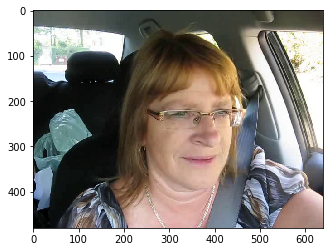

In [40]:
plt.imshow(plt.imread("./train/no_yawn/1067.jpg"))

In [43]:
prediction = model.predict([prepare("./closed.jpg")])
np.argmax(prediction)

2

In [3]:
prediction = model.predict([prepare("./yawning.jpg")])
np.argmax(prediction)

NameError: name 'model' is not defined

In [4]:
import tensorflow as tf
import cv2
import numpy as np
IMG_SIZE = 145
def prepare(filepath, face_cas="./haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
model = tf.keras.models.load_model("./drowiness_new6.h5")
prediction = model.predict([prepare("./train/Closed/_67.jpg")])
np.argmax(prediction)

ModuleNotFoundError: No module named 'tensorflow'

In [15]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread("./train/Closed/_67.jpg"))

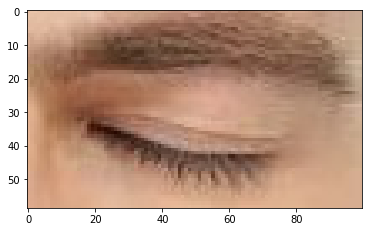

In [16]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread("./train/Closed/_67.jpg"))

In [17]:
prediction = model.predict([prepare("./rightEye.jpg")])
np.argmax(prediction)

2

In [18]:
prediction = model.predict([prepare("./leftEye.jpg")])
np.argmax(prediction)

2

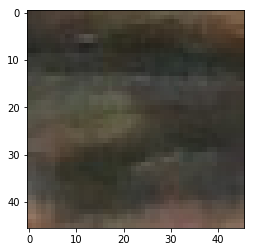

In [19]:
plt.imshow(plt.imread("./rightEye.jpg"))

In [11]:

import cv2
import numpy as np
import tensorflow as tf
IMG_SIZE = 145
def prepare(filepath, face_cas="./haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
model = tf.keras.models.load_model("./drowiness_new6.h5")
prediction = model.predict([prepare("./closed.jpg")])
np.argmax(prediction)

2